In [20]:
import io
import numpy as np
import matplotlib.pyplot as plt
import zarr
import skimage as ski
from PIL import Image

def _select_dataset(root, min_dim_size=1000):
    """ Walk backwards through datasets to find one with 
        the min dimension size in at least one direction.
    """
    multiscale = root['/'].attrs['multiscales'][0]
    selected_dataset = None
    for i in range(len(multiscale['datasets']) - 1, -1, -1):
        dataset_candidate = multiscale['datasets'][i]
        path_candidate = dataset_candidate['path']
        time_series_candidate = root[path_candidate]
        # assumes TCZYX
        image_data_candidate = time_series_candidate[0]
        
        if any(dim >= min_dim_size for dim in image_data_candidate.shape):
            selected_dataset = dataset_candidate
            #print(f"Selected dataset at index {i} with shape: {image_data_candidate.shape}")
            break

    if selected_dataset is None:
        # If no dataset has the min dimension size, use the last one as fallback
        selected_dataset = multiscale['datasets'][-1]
        print(f"No dataset with shape >= {min_dim_size} found, using fallback dataset with shape: {root[selected_dataset['path']][0].shape}")

    return selected_dataset


def adjust_brightness(img: np.ndarray, p_lower=0, p_upper=90) -> np.ndarray:
    """ Adjust the brightness of an image by stretching the histogram 
        based on the specified percentiles.
    """
    p_lower, p_upper = np.percentile(img, (p_lower, p_upper))
    print(f"Adjusting brightness from {p_lower} to {p_upper}")
    return ski.exposure.rescale_intensity(img, in_range=(p_lower, p_upper))

    
def stretch_with_max_gain(channel, p_lower=0.1, p_upper=99.9, max_gain=8, target_max=65535):
    """
    Stretch a single image channel to the full range, but limit the maximum gain.

    Parameters
    ----------
    channel : np.ndarray
        2D array for a single channel (e.g., one fluorescence color).
    p_lower : float
        Lower percentile for contrast stretching (default: 0.1).
    p_upper : float
        Upper percentile for contrast stretching (default: 99.9).
    max_gain : float
        Maximum allowed gain (e.g., 8-32). Limits how much a narrow range can be amplified.
    target_max : int
        Target maximum value (65535 for 16-bit output, 255 for 8-bit).

    Returns
    -------
    np.ndarray
        Contrast-stretched channel with gain capped.
    """
    # Convert to float for safe math
    ch_float = channel.astype(np.float32)

    bias = 300.0
    ch_float = np.clip(ch_float - bias, 0, None)

    # Compute lower and upper percentiles
    lo = np.percentile(ch_float, p_lower)
    hi = np.percentile(ch_float, p_upper)
    #if lo<400: lo = 400
    print(f"Lower percentile: {lo}, Upper percentile: {hi}")

    # Calculate the range, ensuring it's not zero
    dynamic_range = max(hi - lo, 1e-6)
    print(f"Dynamic range: {dynamic_range}")

    #if dynamic_range < 300:
    #    print(f"Dynamic range is too small, returning channel as-is")
    #    return channel

    # Calculate the stretch gain
    gain = target_max / dynamic_range
    print(f"Gain: {gain}")

    if gain>max_gain:
        print(f"Gain is too high, capping at {max_gain}")

    # Cap the gain if it's too high
    gain = min(gain, max_gain)

    # Apply the stretch
    stretched = (ch_float - lo) * gain

    # Clip to the valid range
    stretched = np.clip(stretched, 0, target_max)

    return stretched.astype(np.uint16)


from scipy.stats import median_abs_deviation as mad

def stretch_with_max_gain_bg_guard(
    channel,
    p_lower=0.1,
    p_upper=99.9,
    max_gain=8.0,
    target_max=65535,
    ignore_zeros=True,
    k_bg=5.0,           # how many MADs above the black level we consider "background floor"
    min_dynamic=1e-6
):
    ch = channel.astype(np.float32)

    # Optionally ignore zeros which otherwise swamp the lower percentile
    if ignore_zeros:
        vals = ch[ch > 0]
        if vals.size == 0:
            return np.zeros_like(channel, dtype=np.uint16)
    else:
        vals = ch

    print(f"Using {vals.size} non-zero values out of {ch.size} total values")

    # Estimate black level from the dark tail (robust)
    # Take the bottom 5% to get a dark subset, compute its median and MAD
    dark_cut = np.percentile(vals, 5.0)
    dark_vals = vals[vals <= dark_cut]
    if dark_vals.size == 0:
        dark_vals = vals  # fallback

    black_med = np.median(dark_vals)
    black_mad = mad(dark_vals, scale='normal')  # ~= sigma for Gaussian
    black_floor = black_med + k_bg * (black_mad if np.isfinite(black_mad) else 0.0)
    print(f"Black floor: {black_floor}")

    # Compute percentiles on nonzero vals
    lo_p = np.percentile(vals, p_lower)
    hi_p = np.percentile(vals, p_upper)
    print(f"Lower percentile: {lo_p}, Upper percentile: {hi_p}")

    # Use the larger of the two for the lower bound so we don't raise dark background
    lo = max(lo_p, black_floor)
    hi = max(hi_p, lo + min_dynamic)
    print(f"Lower bound: {lo}, Upper bound: {hi}")

    dynamic_range = max(hi - lo, min_dynamic)
    print(f"Dynamic range: {dynamic_range}")

    # Calculate the stretch gain
    gain = target_max / dynamic_range
    print(f"Gain: {gain}")

    if gain>max_gain:
        print(f"Gain is too high, capping at {max_gain}")

    # Cap the gain if it's too high
    gain = min(gain, max_gain)

    stretched = (ch - lo) * gain
    stretched = np.clip(stretched, 0, target_max)
    return stretched.astype(np.uint16)

In [21]:
from microfilm import colorify
from skimage import exposure
import matplotlib.pyplot as plt

def make_mip(zarr_path, display=False):
    store = zarr.DirectoryStore(zarr_path)
    root = zarr.open(store, mode='r')

    colors = [c['color'] for c in root['/'].attrs['omero']['channels']]
    multiscale = root['/'].attrs['multiscales'][0]
    dataset = _select_dataset(root, min_dim_size=2000)
    path = dataset['path']
    time_series = root[path]
    image_data = time_series[0] # TCZYX

    if display:    
        print(colors)
        print(multiscale)
        print(dataset)
        print(image_data.shape)

    # Assuming image_data is of shape (C, Z, Y, X) where C is the number of channels
    num_channels = image_data.shape[0]
    num_slices = image_data.shape[1]  # This is the Z-axis size
    height = image_data.shape[2]      # Y dimension
    width = image_data.shape[3]       # X dimension

    # Create MIP for each channel
    mip_image_list = []
    for c in range(num_channels):
        channel_data = image_data[c, :, :, :]  # Extract the data for channel c

        # Sometimes the image is all black because the dynamic range is too low.
        # Let's stretch the contrast for display.
        
        if display:
            print(f"Shape of channel_data: {channel_data.shape}")
            print(f"Mean: {channel_data.mean()}, Stddev: {channel_data.std()}, Min: {channel_data.min()}, Max: {channel_data.max()}")
            percentiles = [0.5, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 99.5, 99.9, 99.99]
            percentile_values = np.percentile(channel_data, percentiles)
            for p, val in zip(percentiles, percentile_values):
                print(f"Percentile {p}: {val}")

        mip_image = np.max(channel_data, axis=0)  # Perform the MIP across Z-axis

        #mip_image = adjust_brightness(mip_image, 0.1, 99.9)
        #mip_image = stretch_with_max_gain(mip_image, 0.1, 99.5, max_gain=8)
        mip_image = stretch_with_max_gain_bg_guard(mip_image, 0.1, 99.9, max_gain=5)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        # skimage expects float images in [0, 1] for CLAHE
        mip_image_clahe = exposure.equalize_adapthist(mip_image, clip_limit=0.06)

        if display: 
            # Plot raw MIP and CLAHE-processed MIP side by side
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            # Show the raw MIP image
            axs[0].imshow(mip_image, cmap='gray')
            axs[0].set_title('Raw MIP')
            axs[0].axis('off')

            # Show CLAHE-enhanced MIP
            axs[1].imshow(mip_image_clahe, cmap='gray')
            axs[1].set_title('CLAHE')
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()

        # Overwrite mip_image with the CLAHE result for downstream usage
        mip_image_list.append(mip_image_clahe)

    # Use colorify_by_hex to create colored versions of each channel
    colored_images = []
    for i, mip_image in enumerate(mip_image_list):
        # Get the color for this channel, cycling through available colors
        color_hex = colors[i % len(colors)]

        # Colorify the image using the hex color
        colored_image, _, _ = colorify.colorify_by_hex(mip_image, cmap_hex='#'+color_hex)

        if display:
            print(f"Shape of colored_image: {colored_image.shape}")
            print(f"Mean: {colored_image.mean()}, Stddev: {colored_image.std()}, Min: {colored_image.min()}, Max: {colored_image.max()}")
            print(f"Channel {i} colored with {color_hex}")

        #colored_image = adjust_brightness(colored_image, 10, 74)
        #colored_image = exposure.equalize_adapthist(colored_image, clip_limit=0.01)
        #colored_image = adjust_brightness3(colored_image)
            
        if display:
            plt.imshow(colored_image)
            plt.axis('off')
            plt.show()

        colored_images.append(colored_image)

    # Combine all colored images into a single multi-color image
    if len(colored_images) == 1:
        combined_image = colored_images[0]
    else:
        combined_image = colorify.combine_image(colored_images)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(combined_image)
    ax.axis('off')

    # We need to jump through some hoops to save the figure to a buffer
    # in memory (instead of a file) and convert it to a numpy array,
    # so that it can be processed further (e.g. for brightness adjustment).
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure to free up memory
    buf.seek(0)
    with Image.open(buf) as img:
        mip = np.array(img)

    #adjusted = adjust_brightness(mip, 30, 80)
    #adjusted = exposure.equalize_adapthist(mip, clip_limit=0.03)
    return mip



['0000FF', 'FF8000', 'FF00FF']
{'metadata': {'method': 'loci.common.image.SimpleImageScaler', 'version': 'Bio-Formats 8.3.0'}, 'axes': [{'name': 't', 'type': 'time'}, {'name': 'c', 'type': 'channel'}, {'unit': 'micrometer', 'name': 'z', 'type': 'space'}, {'unit': 'micrometer', 'name': 'y', 'type': 'space'}, {'unit': 'micrometer', 'name': 'x', 'type': 'space'}], 'name': 'Slide 4 of 3_Region 003_channels.tiff', 'datasets': [{'path': '0', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 0.335762932896614, 0.335762932896614], 'type': 'scale'}]}, {'path': '1', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 0.671525865793228, 0.671525865793228], 'type': 'scale'}]}, {'path': '2', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 1.343051731586456, 1.343051731586456], 'type': 'scale'}]}, {'path': '3', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 2.686103463172912, 2.686103463172912], 'type': 'scale'}]}, {'path': '4', 'coordinateTransformations': [{'scale': [1.0

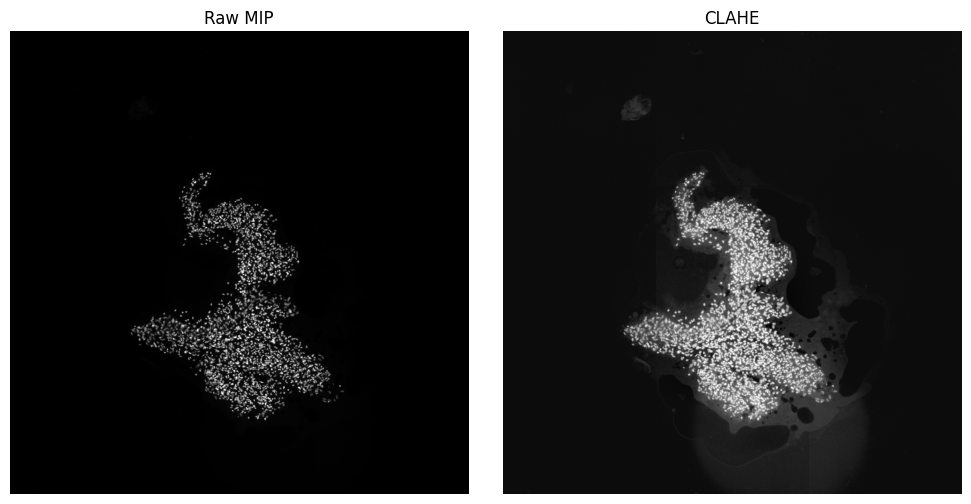

Shape of channel_data: (1, 2817, 2793)
Mean: 205.794855184007, Stddev: 131.81267106989324, Min: 61, Max: 1129
Percentile 0.5: 111.0
Percentile 1: 114.0
Percentile 10: 131.0
Percentile 20: 139.0
Percentile 30: 145.0
Percentile 40: 151.0
Percentile 50: 157.0
Percentile 60: 166.0
Percentile 70: 180.0
Percentile 80: 224.0
Percentile 90: 327.0
Percentile 99: 740.0
Percentile 99.5: 796.0
Percentile 99.9: 871.0
Percentile 99.99: 935.0
Using 7867881 non-zero values out of 7867881 total values
Black floor: 142.23902893066406
Lower percentile: 103.0, Upper percentile: 871.0
Lower bound: 142.23902893066406, Upper bound: 871.0
Dynamic range: 728.760986328125
Gain: 89.92660522460938
Gain is too high, capping at 5


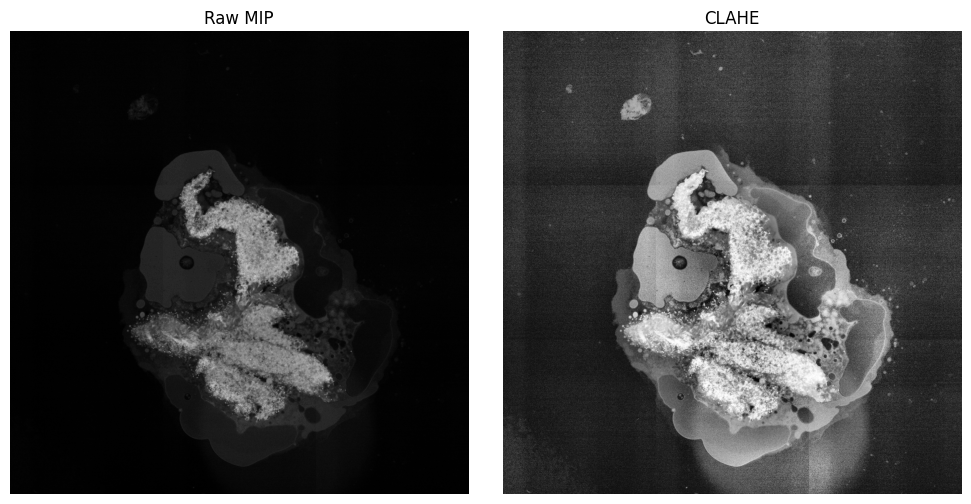

Shape of channel_data: (1, 2817, 2793)
Mean: 125.75192278581743, Stddev: 71.20381733814209, Min: 34, Max: 2672
Percentile 0.5: 87.0
Percentile 1: 89.0
Percentile 10: 98.0
Percentile 20: 102.0
Percentile 30: 106.0
Percentile 40: 108.0
Percentile 50: 111.0
Percentile 60: 114.0
Percentile 70: 118.0
Percentile 80: 125.0
Percentile 90: 144.0
Percentile 99: 479.0
Percentile 99.5: 624.0
Percentile 99.9: 943.0
Percentile 99.99: 1419.0
Using 7867881 non-zero values out of 7867881 total values
Black floor: 107.82601928710938
Lower percentile: 82.0, Upper percentile: 943.0
Lower bound: 107.82601928710938, Upper bound: 943.0
Dynamic range: 835.1739501953125
Gain: 78.46868133544922
Gain is too high, capping at 5


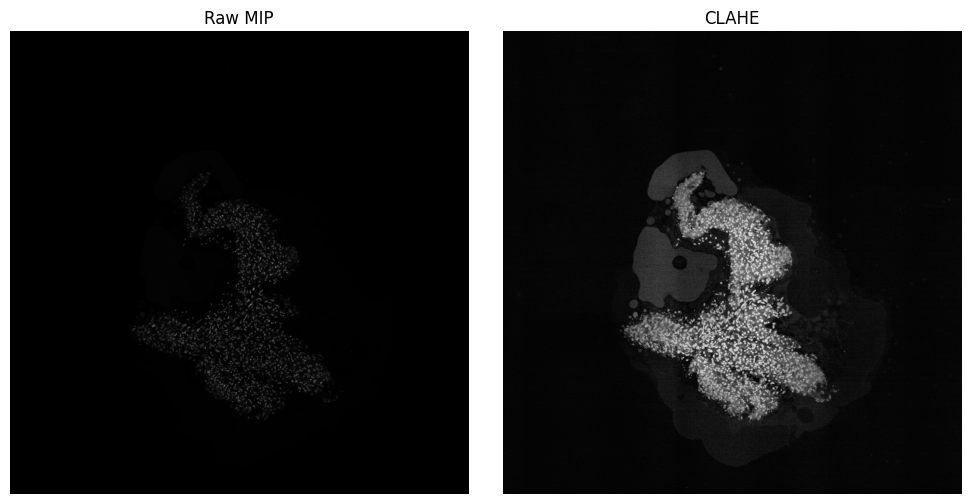

Shape of colored_image: (2817, 2793, 4)
Mean: 0.27622611189098883, Stddev: 0.42729793940018723, Min: 0.0, Max: 1.0
Channel 0 colored with 0000FF


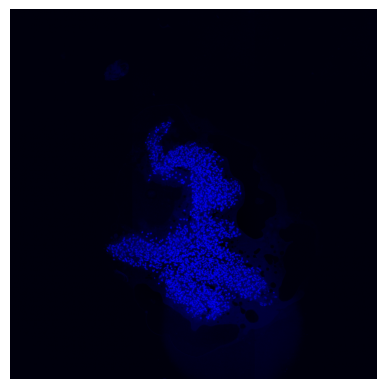

Shape of colored_image: (2817, 2793, 4)
Mean: 0.35793185060409716, Stddev: 0.4073620135585852, Min: 0.0, Max: 1.0
Channel 1 colored with FF8000


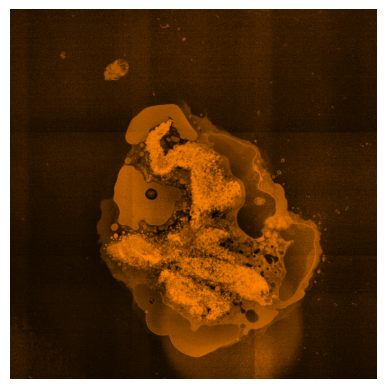

Shape of colored_image: (2817, 2793, 4)
Mean: 0.2849952986195446, Stddev: 0.4250205383638525, Min: 0.0, Max: 1.0
Channel 2 colored with FF00FF


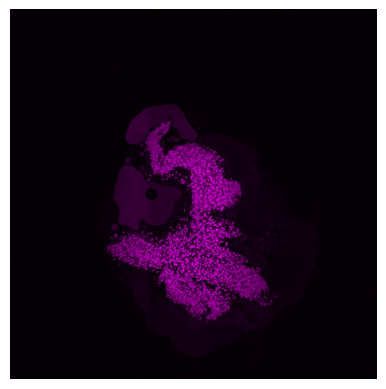

Shape of mip: (770, 763, 4)
Mean: 98.41534484519413, Stddev: 98.46445269905348, Min: 0, Max: 255
Percentile 50: 46.0
Percentile 75: 254.25
Percentile 80: 255.0
Percentile 90: 255.0
Percentile 95: 255.0
Percentile 98: 255.0
Percentile 99: 255.0


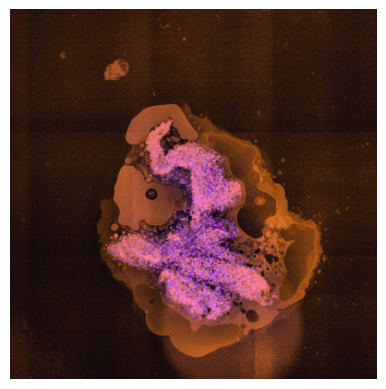

In [22]:

base_path = '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/'
zarr_path = f'{base_path}/ABC-SiRh_Brain_20240815_Slide_5_from_cassette_1_Region_005_channels.zarr'
zarr_path = f'{base_path}/JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr'
zarr_path = f'{base_path}/JF632_Brain_20241001_Slide_1_from_cassette_2_Region_006_channels.zarr'
zarr_path = f'{base_path}/SHAM_Brain_20250829_Slide_6_of_1_Region_005_channels.zarr'
zarr_path = f'{base_path}/FSiRhQ_Brain_20250829_Slide_3_of_2_Region_005_channels.zarr'
zarr_path = f'{base_path}/SiR712_Brain_20250829_Slide_4_of_2_Region_005_channels.zarr'
zarr_path = f'{base_path}/JF698_Brain_20250829_Slide_8_of_1_Region_003_channels.zarr'
zarr_path = f'{base_path}/TEST_JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr'
zarr_path = f'{base_path}/SiR650_Celiacganglia_20250530_Slide_4_of_3_Region_003_channels.zarr'

mip = make_mip(zarr_path, display=True)

print(f"Shape of mip: {mip.shape}")
print(f"Mean: {mip.mean()}, Stddev: {mip.std()}, Min: {mip.min()}, Max: {mip.max()}")
percentiles = [50, 75, 80, 90, 95, 98, 99]
percentile_values = np.percentile(mip, percentiles)
for p, val in zip(percentiles, percentile_values):
    print(f"Percentile {p}: {val}")

plt.imshow(mip)
plt.axis('off')
plt.show()

Found zarr containers: ['/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/ABC-SiRh_Brain_20240815_Slide_5_from_cassette_1_Region_005_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/FABC-SiRh_Brain_20240816_Slide_5_from_cassette_2_Region_002_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/FSiRhQ_Brain_20250829_Slide_3_of_2_Region_005_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/JF632_Brain_20241001_Slide_1_from_cassette_2_Region_006_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/JF632_Brain_20250530_Slide_9_of_3_Region_005_channels.zarr', '/groups/lavis/lavislab/data_external/Dye_Bioavailabil

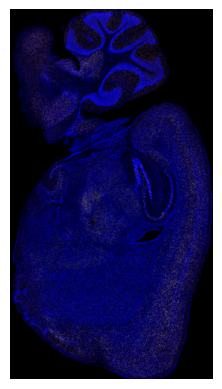

Processing FABC-SiRh_Brain_20240816_Slide_5_from_cassette_2_Region_002_channels.zarr
Using 2244253 non-zero values out of 2624583 total values
Black floor: 212.78216552734375
Lower percentile: 15.0, Upper percentile: 2764.0
Lower bound: 212.78216552734375, Upper bound: 2764.0
Dynamic range: 2551.2177734375
Gain: 25.687732696533203
Gain is too high, capping at 5
Using 2248107 non-zero values out of 2624583 total values
Black floor: 151.4780731201172
Lower percentile: 42.0, Upper percentile: 3025.0
Lower bound: 151.4780731201172, Upper bound: 3025.0
Dynamic range: 2873.52197265625
Gain: 22.806507110595703
Gain is too high, capping at 5
Using 2242254 non-zero values out of 2624583 total values
Black floor: 140.4780731201172
Lower percentile: 24.0, Upper percentile: 5405.75
Lower bound: 140.4780731201172, Upper bound: 5405.75
Dynamic range: 5265.27197265625
Gain: 12.446650505065918
Gain is too high, capping at 5
Using 2251358 non-zero values out of 2624583 total values
Black floor: 156.065

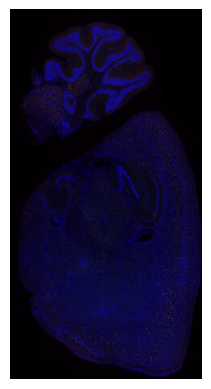

Processing FSiRhQ_Brain_20250829_Slide_3_of_2_Region_005_channels.zarr
Using 2432249 non-zero values out of 2887716 total values
Black floor: 175.89108276367188
Lower percentile: 94.0, Upper percentile: 3157.75
Lower bound: 175.89108276367188, Upper bound: 3157.75
Dynamic range: 2981.85888671875
Gain: 21.977901458740234
Gain is too high, capping at 5
Using 2432198 non-zero values out of 2887716 total values
Black floor: 157.4780731201172
Lower percentile: 86.0, Upper percentile: 20284.0
Lower bound: 157.4780731201172, Upper bound: 20284.0
Dynamic range: 20126.521484375
Gain: 3.2561514377593994
Using 2432147 non-zero values out of 2887716 total values
Black floor: 135.0650634765625
Lower percentile: 77.0, Upper percentile: 27144.0
Lower bound: 135.0650634765625, Upper bound: 27144.0
Dynamic range: 27008.935546875
Gain: 2.426419258117676
Using 2432251 non-zero values out of 2887716 total values
Black floor: 156.0650634765625
Lower percentile: 93.0, Upper percentile: 258.0
Lower bound: 15

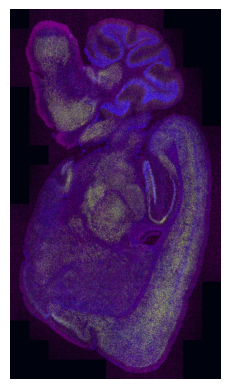

Processing JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr
Using 2623604 non-zero values out of 4129274 total values
Black floor: 178.30409240722656
Lower percentile: 57.0, Upper percentile: 1283.0
Lower bound: 178.30409240722656, Upper bound: 1283.0
Dynamic range: 1104.6959228515625
Gain: 59.32401657104492
Gain is too high, capping at 5
Using 2598422 non-zero values out of 4129274 total values
Black floor: 174.13011169433594
Lower percentile: 11.0, Upper percentile: 6244.5
Lower bound: 174.13011169433594, Upper bound: 6244.5
Dynamic range: 6070.3701171875
Gain: 10.795882225036621
Gain is too high, capping at 5
Using 2624026 non-zero values out of 4129274 total values
Black floor: 139.0650634765625
Lower percentile: 78.0, Upper percentile: 1319.0
Lower bound: 139.0650634765625, Upper bound: 1319.0
Dynamic range: 1179.9349365234375
Gain: 55.54119873046875
Gain is too high, capping at 5
Using 2600901 non-zero values out of 4129274 total values
Black floor: 192.36914

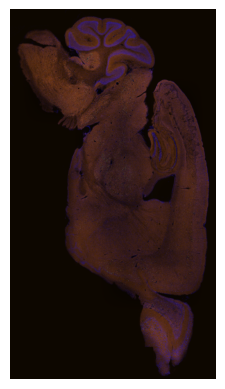

Processing JF632_Brain_20241001_Slide_1_from_cassette_2_Region_006_channels.zarr
Using 2376618 non-zero values out of 2887716 total values
Black floor: 178.30409240722656
Lower percentile: 59.0, Upper percentile: 981.0
Lower bound: 178.30409240722656, Upper bound: 981.0
Dynamic range: 802.6959228515625
Gain: 81.64361572265625
Gain is too high, capping at 5
Using 2231273 non-zero values out of 2887716 total values
Black floor: 200.26022338867188
Lower percentile: 3.0, Upper percentile: 11514.75
Lower bound: 200.26022338867188, Upper bound: 11514.75
Dynamic range: 11314.490234375
Gain: 5.792129993438721
Gain is too high, capping at 5
Using 2212922 non-zero values out of 2887716 total values
Black floor: 205.0211944580078
Lower percentile: 4.0, Upper percentile: 22881.0
Lower bound: 205.0211944580078, Upper bound: 22881.0
Dynamic range: 22675.978515625
Gain: 2.8900628089904785
Using 2374899 non-zero values out of 2887716 total values
Black floor: 156.4780731201172
Lower percentile: 68.0, 

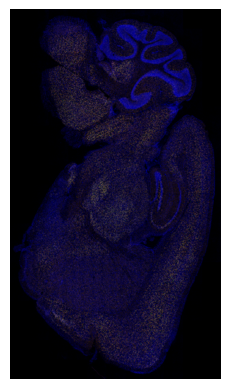

Processing JF632_Brain_20250530_Slide_9_of_3_Region_005_channels.zarr
Using 2413657 non-zero values out of 2999466 total values
Black floor: 3020.14697265625
Lower percentile: 1405.0, Upper percentile: 65535.0
Lower bound: 3020.14697265625, Upper bound: 65535.0
Dynamic range: 62514.8515625
Gain: 1.0483108758926392
Using 2413657 non-zero values out of 2999466 total values
Black floor: 438.4342041015625
Lower percentile: 239.0, Upper percentile: 65535.0
Lower bound: 438.4342041015625, Upper bound: 65535.0
Dynamic range: 65096.56640625
Gain: 1.00673508644104
Using 2413657 non-zero values out of 2999466 total values
Black floor: 122.2390365600586
Lower percentile: 87.0, Upper percentile: 4513.0
Lower bound: 122.2390365600586, Upper bound: 4513.0
Dynamic range: 4390.7607421875
Gain: 14.9256591796875
Gain is too high, capping at 5


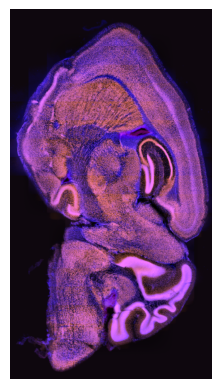

Processing JF632_Celiacganglia_20250530_Slide_12_of_3_Region_002_channels.zarr
Using 5026650 non-zero values out of 9179100 total values
Black floor: 935.1936645507812
Lower percentile: 323.0, Upper percentile: 65535.0
Lower bound: 935.1936645507812, Upper bound: 65535.0
Dynamic range: 64599.8046875
Gain: 1.0144767761230469
Using 5026650 non-zero values out of 9179100 total values
Black floor: 164.65203857421875
Lower percentile: 116.0, Upper percentile: 1625.0
Lower bound: 164.65203857421875, Upper bound: 1625.0
Dynamic range: 1460.347900390625
Gain: 44.87629318237305
Gain is too high, capping at 5
Using 5026650 non-zero values out of 9179100 total values
Black floor: 108.82601928710938
Lower percentile: 83.0, Upper percentile: 1914.5
Lower bound: 108.82601928710938, Upper bound: 1914.5
Dynamic range: 1805.6739501953125
Gain: 36.29392623901367
Gain is too high, capping at 5


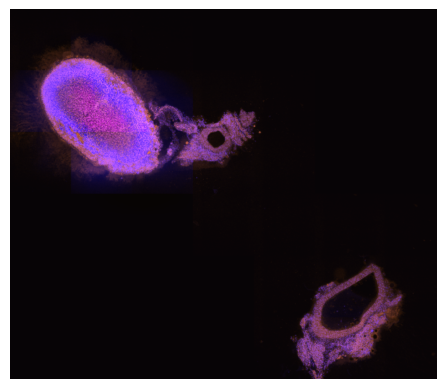

Processing JF632_Liver_20250530_Slide_10_of_4_Region_005_channels.zarr
Using 1402222 non-zero values out of 1808324 total values
Black floor: 1909.5614013671875
Lower percentile: 481.0, Upper percentile: 65535.0
Lower bound: 1909.5614013671875, Upper bound: 65535.0
Dynamic range: 63625.4375
Gain: 1.030012607574463
Using 1402222 non-zero values out of 1808324 total values
Black floor: 263.130126953125
Lower percentile: 142.0, Upper percentile: 5356.0
Lower bound: 263.130126953125, Upper bound: 5356.0
Dynamic range: 5092.8701171875
Gain: 12.867989540100098
Gain is too high, capping at 5
Using 1402222 non-zero values out of 1808324 total values
Black floor: 131.23902893066406
Lower percentile: 93.0, Upper percentile: 2191.0
Lower bound: 131.23902893066406, Upper bound: 2191.0
Dynamic range: 2059.760986328125
Gain: 31.81679916381836
Gain is too high, capping at 5


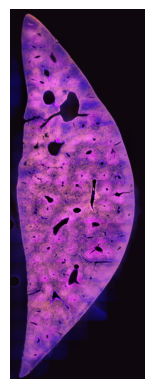

Processing JF632_Lung_20250530_Slide_11_of_4_Region_003_channels.zarr
Using 7851060 non-zero values out of 10468080 total values
Black floor: 1744.758056640625
Lower percentile: 647.0, Upper percentile: 65535.0
Lower bound: 1744.758056640625, Upper bound: 65535.0
Dynamic range: 63790.2421875
Gain: 1.0273514986038208
Using 7851060 non-zero values out of 10468080 total values
Black floor: 205.4780731201172
Lower percentile: 134.0, Upper percentile: 2993.0
Lower bound: 205.4780731201172, Upper bound: 2993.0
Dynamic range: 2787.52197265625
Gain: 23.510128021240234
Gain is too high, capping at 5
Using 7851060 non-zero values out of 10468080 total values
Black floor: 115.82601928710938
Lower percentile: 88.0, Upper percentile: 3521.0
Lower bound: 115.82601928710938, Upper bound: 3521.0
Dynamic range: 3405.174072265625
Gain: 19.245712280273438
Gain is too high, capping at 5


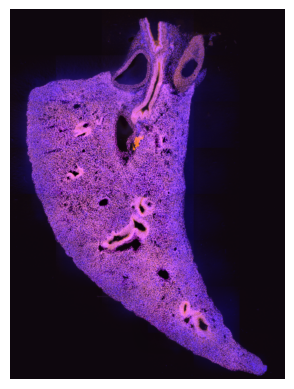

Processing JF632_Nodoseganglia_20250530_Slide_12_of_4_Region_001_channels.zarr
Using 6112890 non-zero values out of 8732700 total values
Black floor: 1048.0635986328125
Lower percentile: 470.0, Upper percentile: 65535.0
Lower bound: 1048.0635986328125, Upper bound: 65535.0
Dynamic range: 64486.9375
Gain: 1.0162522792816162
Using 6112890 non-zero values out of 8732700 total values
Black floor: 175.65203857421875
Lower percentile: 123.0, Upper percentile: 2164.0
Lower bound: 175.65203857421875, Upper bound: 2164.0
Dynamic range: 1988.347900390625
Gain: 32.95952224731445
Gain is too high, capping at 5
Using 6112890 non-zero values out of 8732700 total values
Black floor: 109.82601928710938
Lower percentile: 84.0, Upper percentile: 3225.0
Lower bound: 109.82601928710938, Upper bound: 3225.0
Dynamic range: 3115.174072265625
Gain: 21.0373477935791
Gain is too high, capping at 5


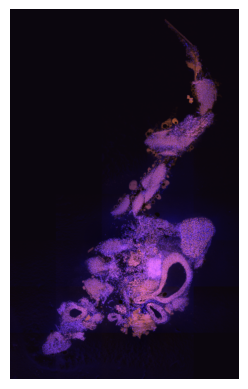

Processing JF632_Pancreas_20250530_Slide_9_of_4_Region_002_channels.zarr
Using 3765689 non-zero values out of 4802520 total values
Black floor: 1981.8018798828125
Lower percentile: 1171.0, Upper percentile: 65535.0
Lower bound: 1981.8018798828125, Upper bound: 65535.0
Dynamic range: 63553.19921875
Gain: 1.0311833620071411
Using 3765689 non-zero values out of 4802520 total values
Black floor: 245.89108276367188
Lower percentile: 157.0, Upper percentile: 2994.0
Lower bound: 245.89108276367188, Upper bound: 2994.0
Dynamic range: 2748.10888671875
Gain: 23.847309112548828
Gain is too high, capping at 5
Using 3765689 non-zero values out of 4802520 total values
Black floor: 124.2390365600586
Lower percentile: 89.0, Upper percentile: 2078.0
Lower bound: 124.2390365600586, Upper bound: 2078.0
Dynamic range: 1953.760986328125
Gain: 33.542999267578125
Gain is too high, capping at 5


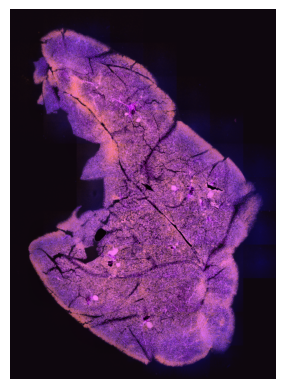

Processing JF632_Salivarygland_20250530_Slide_10_of_3_Region_003_channels.zarr
Using 2288727 non-zero values out of 3432970 total values
Black floor: 1169.5205078125
Lower percentile: 693.0, Upper percentile: 65535.0
Lower bound: 1169.5205078125, Upper bound: 65535.0
Dynamic range: 64365.48046875
Gain: 1.0181699991226196
Using 2288727 non-zero values out of 3432970 total values
Black floor: 210.4780731201172
Lower percentile: 136.0, Upper percentile: 4600.0
Lower bound: 210.4780731201172, Upper bound: 4600.0
Dynamic range: 4389.52197265625
Gain: 14.929871559143066
Gain is too high, capping at 5
Using 2288727 non-zero values out of 3432970 total values
Black floor: 127.2390365600586
Lower percentile: 91.0, Upper percentile: 2685.0
Lower bound: 127.2390365600586, Upper bound: 2685.0
Dynamic range: 2557.760986328125
Gain: 25.622018814086914
Gain is too high, capping at 5


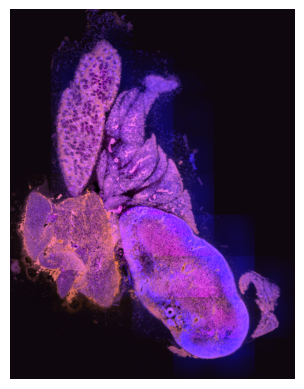

Processing JF632_Spinalcord_20250530_Slide_11_of_3_Region_002_channels.zarr
Using 1183439 non-zero values out of 2094148 total values
Black floor: 658.5643310546875
Lower percentile: 360.0, Upper percentile: 65535.0
Lower bound: 658.5643310546875, Upper bound: 65535.0
Dynamic range: 64876.4375
Gain: 1.0101510286331177
Using 1183439 non-zero values out of 2094148 total values
Black floor: 180.0650634765625
Lower percentile: 120.0, Upper percentile: 25720.0
Lower bound: 180.0650634765625, Upper bound: 25720.0
Dynamic range: 25539.935546875
Gain: 2.565981388092041
Using 1183439 non-zero values out of 2094148 total values
Black floor: 109.82601928710938
Lower percentile: 83.0, Upper percentile: 592.0
Lower bound: 109.82601928710938, Upper bound: 592.0
Dynamic range: 482.1739807128906
Gain: 135.91566467285156
Gain is too high, capping at 5


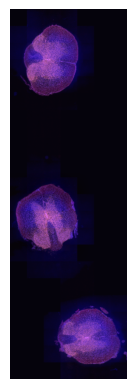

Processing JF635_Brain_20250829_Slide_5_of_1_Region_006_channels.zarr
Using 2141273 non-zero values out of 2485710 total values
Black floor: 246.54312133789062
Lower percentile: 116.0, Upper percentile: 3833.0
Lower bound: 246.54312133789062, Upper bound: 3833.0
Dynamic range: 3586.456787109375
Gain: 18.27290916442871
Gain is too high, capping at 5
Using 2141245 non-zero values out of 2485710 total values
Black floor: 169.89108276367188
Lower percentile: 89.0, Upper percentile: 17637.0
Lower bound: 169.89108276367188, Upper bound: 17637.0
Dynamic range: 17467.109375
Gain: 3.751908779144287
Using 2141218 non-zero values out of 2485710 total values
Black floor: 138.0650634765625
Lower percentile: 78.0, Upper percentile: 24972.25
Lower bound: 138.0650634765625, Upper bound: 24972.25
Dynamic range: 24834.185546875
Gain: 2.6389026641845703
Using 2141270 non-zero values out of 2485710 total values
Black floor: 167.4780731201172
Lower percentile: 96.0, Upper percentile: 2212.0
Lower bound: 16

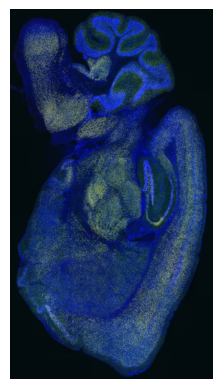

Processing JF646_Brain_20250829_Slide_5_of_2_Region_005_channels.zarr
Using 2196729 non-zero values out of 2624583 total values
Black floor: 230.54312133789062
Lower percentile: 107.0, Upper percentile: 4492.0
Lower bound: 230.54312133789062, Upper bound: 4492.0
Dynamic range: 4261.45703125
Gain: 15.37854290008545
Gain is too high, capping at 5
Using 2196721 non-zero values out of 2624583 total values
Black floor: 159.4780731201172
Lower percentile: 88.0, Upper percentile: 10985.0
Lower bound: 159.4780731201172, Upper bound: 10985.0
Dynamic range: 10825.521484375
Gain: 6.053750038146973
Gain is too high, capping at 5
Using 2196722 non-zero values out of 2624583 total values
Black floor: 136.0650634765625
Lower percentile: 79.0, Upper percentile: 8890.0
Lower bound: 136.0650634765625, Upper bound: 8890.0
Dynamic range: 8753.9345703125
Gain: 7.4863481521606445
Gain is too high, capping at 5
Using 2196693 non-zero values out of 2624583 total values
Black floor: 164.4780731201172
Lower per

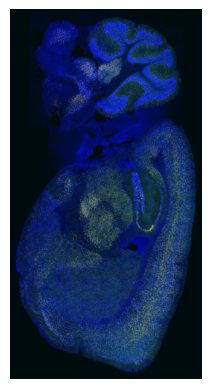

Processing JF657_Brain_20250829_Slide_4_of_1_Region_005_channels.zarr
Using 2238382 non-zero values out of 2887716 total values
Black floor: 235.54312133789062
Lower percentile: 112.0, Upper percentile: 3845.0
Lower bound: 235.54312133789062, Upper bound: 3845.0
Dynamic range: 3609.456787109375
Gain: 18.156471252441406
Gain is too high, capping at 5
Using 2238355 non-zero values out of 2887716 total values
Black floor: 167.89108276367188
Lower percentile: 88.0, Upper percentile: 15903.5
Lower bound: 167.89108276367188, Upper bound: 15903.5
Dynamic range: 15735.609375
Gain: 4.16475772857666
Using 2238317 non-zero values out of 2887716 total values
Black floor: 137.0650634765625
Lower percentile: 77.0, Upper percentile: 24700.5
Lower bound: 137.0650634765625, Upper bound: 24700.5
Dynamic range: 24563.435546875
Gain: 2.66798996925354
Using 2238384 non-zero values out of 2887716 total values
Black floor: 159.0650634765625
Lower percentile: 96.0, Upper percentile: 274.0
Lower bound: 159.065

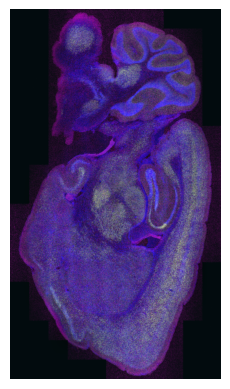

Processing JF669_Brain_20240816_Slide_1_from_cassette_2_Region_005_channels.zarr
Using 2287756 non-zero values out of 2984130 total values
Black floor: 210.369140625
Lower percentile: 19.0, Upper percentile: 2443.0
Lower bound: 210.369140625, Upper bound: 2443.0
Dynamic range: 2232.630859375
Gain: 29.353261947631836
Gain is too high, capping at 5
Using 2170217 non-zero values out of 2984130 total values
Black floor: 215.67323303222656
Lower percentile: 3.0, Upper percentile: 13131.5
Lower bound: 215.67323303222656, Upper bound: 13131.5
Dynamic range: 12915.8271484375
Gain: 5.074007034301758
Gain is too high, capping at 5
Using 2248061 non-zero values out of 2984130 total values
Black floor: 185.19517517089844
Lower percentile: 6.0, Upper percentile: 5532.0
Lower bound: 185.19517517089844, Upper bound: 5532.0
Dynamic range: 5346.8046875
Gain: 12.256853103637695
Gain is too high, capping at 5
Using 2181603 non-zero values out of 2984130 total values
Black floor: 212.67323303222656
Lower 

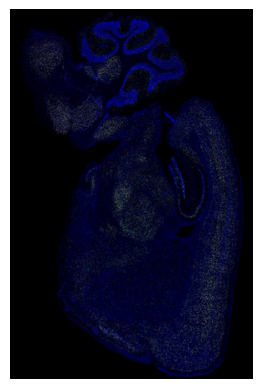

Processing JF698_Brain_20250829_Slide_8_of_1_Region_003_channels.zarr
Using 2265998 non-zero values out of 2887716 total values
Black floor: 193.30409240722656
Lower percentile: 99.0, Upper percentile: 4884.0
Lower bound: 193.30409240722656, Upper bound: 4884.0
Dynamic range: 4690.69580078125
Gain: 13.971274375915527
Gain is too high, capping at 5
Using 2265980 non-zero values out of 2887716 total values
Black floor: 160.4780731201172
Lower percentile: 88.0, Upper percentile: 11940.0
Lower bound: 160.4780731201172, Upper bound: 11940.0
Dynamic range: 11779.521484375
Gain: 5.563468933105469
Gain is too high, capping at 5
Using 2265945 non-zero values out of 2887716 total values
Black floor: 139.0650634765625
Lower percentile: 79.0, Upper percentile: 22260.0
Lower bound: 139.0650634765625, Upper bound: 22260.0
Dynamic range: 22120.935546875
Gain: 2.962578058242798
Using 2265998 non-zero values out of 2887716 total values
Black floor: 156.0650634765625
Lower percentile: 94.0, Upper percen

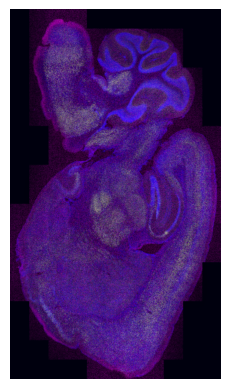

Processing JF722_Brain_20250829_Slide_7_of_2_Region_005_channels.zarr
Using 2238266 non-zero values out of 2734920 total values
Black floor: 189.30409240722656
Lower percentile: 95.0, Upper percentile: 4374.0
Lower bound: 189.30409240722656, Upper bound: 4374.0
Dynamic range: 4184.69580078125
Gain: 15.660636901855469
Gain is too high, capping at 5
Using 2238263 non-zero values out of 2734920 total values
Black floor: 158.4780731201172
Lower percentile: 88.0, Upper percentile: 5679.75
Lower bound: 158.4780731201172, Upper bound: 5679.75
Dynamic range: 5521.27197265625
Gain: 11.869547843933105
Gain is too high, capping at 5
Using 2238258 non-zero values out of 2734920 total values
Black floor: 138.0650634765625
Lower percentile: 79.0, Upper percentile: 8978.0
Lower bound: 138.0650634765625, Upper bound: 8978.0
Dynamic range: 8839.9345703125
Gain: 7.413516521453857
Gain is too high, capping at 5
Using 2238268 non-zero values out of 2734920 total values
Black floor: 156.0650634765625
Lower

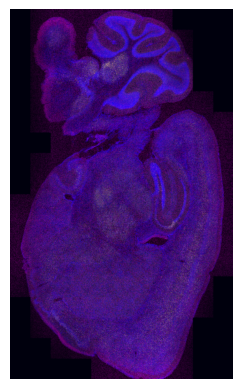

Processing JFx650_Brain_20250829_Slide_3_of_1_Region_006_channels.zarr
Using 2346027 non-zero values out of 2621082 total values
Black floor: 174.89108276367188
Lower percentile: 92.0, Upper percentile: 3073.0
Lower bound: 174.89108276367188, Upper bound: 3073.0
Dynamic range: 2898.10888671875
Gain: 22.613021850585938
Gain is too high, capping at 5
Using 2346010 non-zero values out of 2621082 total values
Black floor: 157.4780731201172
Lower percentile: 87.0, Upper percentile: 11280.0
Lower bound: 157.4780731201172, Upper bound: 11280.0
Dynamic range: 11122.521484375
Gain: 5.892099380493164
Gain is too high, capping at 5
Using 2346011 non-zero values out of 2621082 total values
Black floor: 136.0650634765625
Lower percentile: 77.0, Upper percentile: 14734.0
Lower bound: 136.0650634765625, Upper bound: 14734.0
Dynamic range: 14597.9345703125
Gain: 4.489333629608154
Using 2345982 non-zero values out of 2621082 total values
Black floor: 167.4780731201172
Lower percentile: 95.0, Upper perc

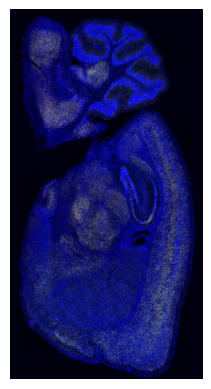

Processing JFx673_Brain_20250530_Slide_5_of_3_Region_005_channels.zarr
Using 2263203 non-zero values out of 2699136 total values
Black floor: 2574.2998046875
Lower percentile: 929.0, Upper percentile: 65535.0
Lower bound: 2574.2998046875, Upper bound: 65535.0
Dynamic range: 62960.69921875
Gain: 1.040887475013733
Using 2263203 non-zero values out of 2699136 total values
Black floor: 399.2602233886719
Lower percentile: 186.0, Upper percentile: 59805.25
Lower bound: 399.2602233886719, Upper bound: 59805.25
Dynamic range: 59405.98828125
Gain: 1.1031715869903564
Using 2263203 non-zero values out of 2699136 total values
Black floor: 127.2390365600586
Lower percentile: 90.0, Upper percentile: 4095.0
Lower bound: 127.2390365600586, Upper bound: 4095.0
Dynamic range: 3967.760986328125
Gain: 16.51687240600586
Gain is too high, capping at 5


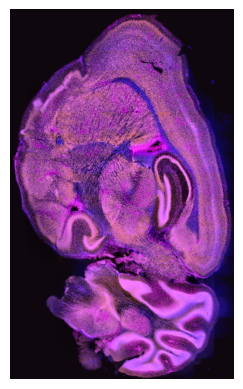

Processing JFx673_Brain_20250829_Slide_1_of_1_Region_005_channels.zarr
Using 2196730 non-zero values out of 2485710 total values
Black floor: 175.89108276367188
Lower percentile: 94.0, Upper percentile: 2293.0
Lower bound: 175.89108276367188, Upper bound: 2293.0
Dynamic range: 2117.10888671875
Gain: 30.9549503326416
Gain is too high, capping at 5
Using 2196729 non-zero values out of 2485710 total values
Black floor: 151.0650634765625
Lower percentile: 88.0, Upper percentile: 6496.5
Lower bound: 151.0650634765625, Upper bound: 6496.5
Dynamic range: 6345.43505859375
Gain: 10.327897071838379
Gain is too high, capping at 5
Using 2196727 non-zero values out of 2485710 total values
Black floor: 138.0650634765625
Lower percentile: 79.0, Upper percentile: 6545.25
Lower bound: 138.0650634765625, Upper bound: 6545.25
Dynamic range: 6407.18505859375
Gain: 10.228361129760742
Gain is too high, capping at 5
Using 2196727 non-zero values out of 2485710 total values
Black floor: 160.0650634765625
Lowe

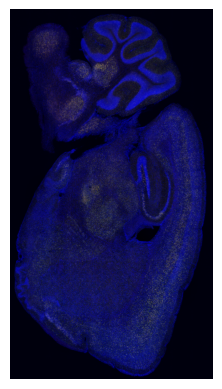

Processing JFx673_Celiacganglia_20250530_Slide_8_of_3_Region_003_channels.zarr
Using 4371000 non-zero values out of 5245200 total values
Black floor: 1204.3253173828125
Lower percentile: 634.0, Upper percentile: 38208.0
Lower bound: 1204.3253173828125, Upper bound: 38208.0
Dynamic range: 37003.67578125
Gain: 1.7710403203964233
Using 4371000 non-zero values out of 5245200 total values
Black floor: 226.4780731201172
Lower percentile: 154.0, Upper percentile: 1847.0
Lower bound: 226.4780731201172, Upper bound: 1847.0
Dynamic range: 1620.52197265625
Gain: 40.440673828125
Gain is too high, capping at 5
Using 4371000 non-zero values out of 5245200 total values
Black floor: 109.82601928710938
Lower percentile: 84.0, Upper percentile: 672.0
Lower bound: 109.82601928710938, Upper bound: 672.0
Dynamic range: 562.1739501953125
Gain: 116.5742416381836
Gain is too high, capping at 5


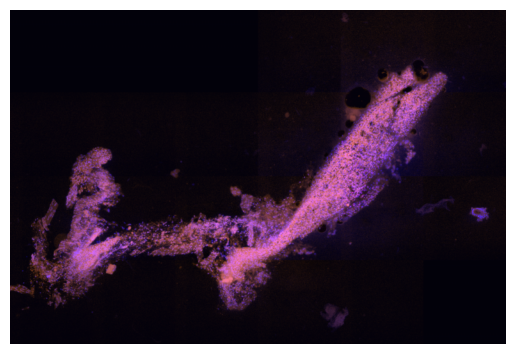

Processing JFx673_Liver_20250530_Slide_6_of_4_Region_004_channels.zarr
Using 1498280 non-zero values out of 2207060 total values
Black floor: 3120.3857421875
Lower percentile: 567.0, Upper percentile: 65535.0
Lower bound: 3120.3857421875, Upper bound: 65535.0
Dynamic range: 62414.61328125
Gain: 1.0499944686889648
Using 1498280 non-zero values out of 2207060 total values
Black floor: 340.1951904296875
Lower percentile: 142.0, Upper percentile: 6259.5
Lower bound: 340.1951904296875, Upper bound: 6259.5
Dynamic range: 5919.3046875
Gain: 11.071401596069336
Gain is too high, capping at 5
Using 1498280 non-zero values out of 2207060 total values
Black floor: 129.23902893066406
Lower percentile: 92.0, Upper percentile: 1352.0
Lower bound: 129.23902893066406, Upper bound: 1352.0
Dynamic range: 1222.760986328125
Gain: 53.59592056274414
Gain is too high, capping at 5


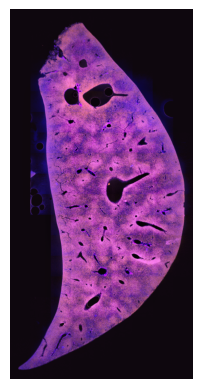

Processing JFx673_Lung_20250530_Slide_7_of_4_Region_004_channels.zarr
Using 2291291 non-zero values out of 3436224 total values
Black floor: 1692.8880615234375
Lower percentile: 354.0, Upper percentile: 65535.0
Lower bound: 1692.8880615234375, Upper bound: 65535.0
Dynamic range: 63842.11328125
Gain: 1.0265167951583862
Using 2291291 non-zero values out of 3436224 total values
Black floor: 193.0650634765625
Lower percentile: 129.0, Upper percentile: 2365.0
Lower bound: 193.0650634765625, Upper bound: 2365.0
Dynamic range: 2171.93505859375
Gain: 30.173553466796875
Gain is too high, capping at 5
Using 2291291 non-zero values out of 3436224 total values
Black floor: 111.82601928710938
Lower percentile: 85.0, Upper percentile: 1686.0
Lower bound: 111.82601928710938, Upper bound: 1686.0
Dynamic range: 1574.1739501953125
Gain: 41.6313591003418
Gain is too high, capping at 5


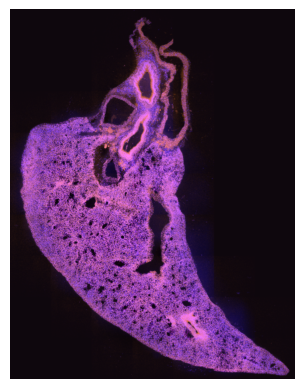

Processing JFx673_Nodoseganglia_20250530_Slide_8_of_4_Region_001_channels.zarr
Using 13927568 non-zero values out of 13927568 total values
Black floor: 462.1951904296875
Lower percentile: 287.0, Upper percentile: 65535.0
Lower bound: 462.1951904296875, Upper bound: 65535.0
Dynamic range: 65072.8046875
Gain: 1.0071027278900146
Using 13927568 non-zero values out of 13927568 total values
Black floor: 164.65203857421875
Lower percentile: 115.0, Upper percentile: 1546.0
Lower bound: 164.65203857421875, Upper bound: 1546.0
Dynamic range: 1381.347900390625
Gain: 47.44279098510742
Gain is too high, capping at 5
Using 13927568 non-zero values out of 13927568 total values
Black floor: 108.82601928710938
Lower percentile: 82.0, Upper percentile: 2243.0
Lower bound: 108.82601928710938, Upper bound: 2243.0
Dynamic range: 2134.174072265625
Gain: 30.707429885864258
Gain is too high, capping at 5


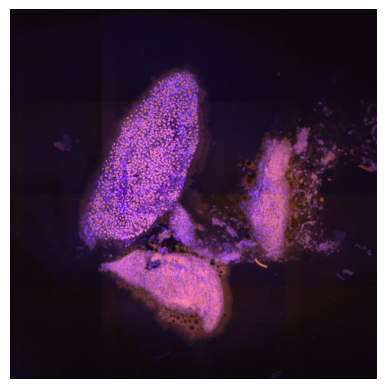

Processing JFx673_Pancreas_20250530_Slide_5_of_4_Region_003_channels.zarr
Using 2233473 non-zero values out of 4577625 total values
Black floor: 2372.343505859375
Lower percentile: 927.0, Upper percentile: 65535.0
Lower bound: 2372.343505859375, Upper bound: 65535.0
Dynamic range: 63162.65625
Gain: 1.0375592708587646
Using 2233473 non-zero values out of 4577625 total values
Black floor: 229.89108276367188
Lower percentile: 146.0, Upper percentile: 3681.0
Lower bound: 229.89108276367188, Upper bound: 3681.0
Dynamic range: 3451.10888671875
Gain: 18.989547729492188
Gain is too high, capping at 5
Using 2233473 non-zero values out of 4577625 total values
Black floor: 113.82601928710938
Lower percentile: 86.0, Upper percentile: 1434.0
Lower bound: 113.82601928710938, Upper bound: 1434.0
Dynamic range: 1320.1739501953125
Gain: 49.64118576049805
Gain is too high, capping at 5


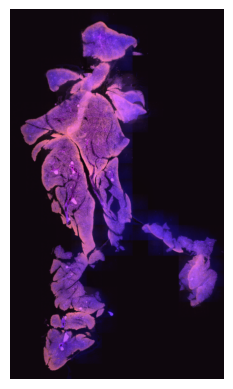

Processing JFx673_Salivarygland_20250530_Slide_6_of_3_Region_004_channels.zarr
Using 3927842 non-zero values out of 4583259 total values
Black floor: 2389.58251953125
Lower percentile: 1058.0, Upper percentile: 65535.0
Lower bound: 2389.58251953125, Upper bound: 65535.0
Dynamic range: 63145.41796875
Gain: 1.0378425121307373
Using 3927842 non-zero values out of 4583259 total values
Black floor: 250.30409240722656
Lower percentile: 156.0, Upper percentile: 3154.0
Lower bound: 250.30409240722656, Upper bound: 3154.0
Dynamic range: 2903.69580078125
Gain: 22.56951332092285
Gain is too high, capping at 5
Using 3927842 non-zero values out of 4583259 total values
Black floor: 128.23902893066406
Lower percentile: 91.0, Upper percentile: 1950.0
Lower bound: 128.23902893066406, Upper bound: 1950.0
Dynamic range: 1821.760986328125
Gain: 35.97343444824219
Gain is too high, capping at 5


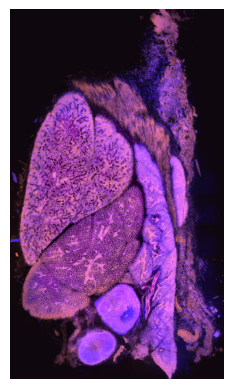

Processing JFx673_Spinalcord_20250530_Slide_7_of_3_Region_002_channels.zarr
Using 913065 non-zero values out of 1360702 total values
Black floor: 2000.928955078125
Lower percentile: 434.0, Upper percentile: 65535.0
Lower bound: 2000.928955078125, Upper bound: 65535.0
Dynamic range: 63534.0703125
Gain: 1.0314937829971313
Using 913065 non-zero values out of 1360702 total values
Black floor: 179.0650634765625
Lower percentile: 119.0, Upper percentile: 18731.0625
Lower bound: 179.0650634765625, Upper bound: 18731.0625
Dynamic range: 18551.998046875
Gain: 3.532503604888916
Using 913065 non-zero values out of 1360702 total values
Black floor: 109.82601928710938
Lower percentile: 83.0, Upper percentile: 3030.0
Lower bound: 109.82601928710938, Upper bound: 3030.0
Dynamic range: 2920.174072265625
Gain: 22.442155838012695
Gain is too high, capping at 5


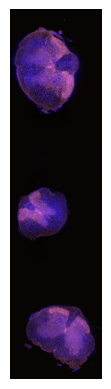

Processing SHAM_Brain_20250829_Slide_6_of_1_Region_005_channels.zarr
Using 2182692 non-zero values out of 2485710 total values
Black floor: 246.95614624023438
Lower percentile: 110.0, Upper percentile: 4153.25
Lower bound: 246.95614624023438, Upper bound: 4153.25
Dynamic range: 3906.2939453125
Gain: 16.776771545410156
Gain is too high, capping at 5
Using 2182684 non-zero values out of 2485710 total values
Black floor: 168.89108276367188
Lower percentile: 88.68310546875, Upper percentile: 10153.75
Lower bound: 168.89108276367188, Upper bound: 10153.75
Dynamic range: 9984.859375
Gain: 6.563437461853027
Gain is too high, capping at 5
Using 2182664 non-zero values out of 2485710 total values
Black floor: 138.0650634765625
Lower percentile: 78.0, Upper percentile: 15358.5
Lower bound: 138.0650634765625, Upper bound: 15358.5
Dynamic range: 15220.4345703125
Gain: 4.305724620819092
Using 2182693 non-zero values out of 2485710 total values
Black floor: 158.0650634765625
Lower percentile: 95.0, 

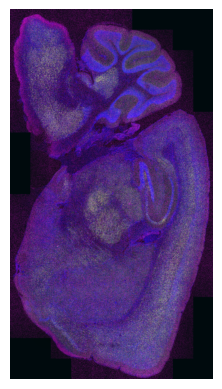

Processing SiR650_Brain_20250530_Slide_1_of_3_Region_003_channels.zarr
Using 2315398 non-zero values out of 2846106 total values
Black floor: 1229.605224609375
Lower percentile: 213.0, Upper percentile: 65535.0
Lower bound: 1229.605224609375, Upper bound: 65535.0
Dynamic range: 64305.39453125
Gain: 1.0191212892532349
Using 2315398 non-zero values out of 2846106 total values
Black floor: 249.95614624023438
Lower percentile: 121.0, Upper percentile: 45462.25
Lower bound: 249.95614624023438, Upper bound: 45462.25
Dynamic range: 45212.29296875
Gain: 1.4494951963424683
Using 2315398 non-zero values out of 2846106 total values
Black floor: 140.65203857421875
Lower percentile: 93.0, Upper percentile: 20038.0
Lower bound: 140.65203857421875, Upper bound: 20038.0
Dynamic range: 19897.34765625
Gain: 3.2936551570892334


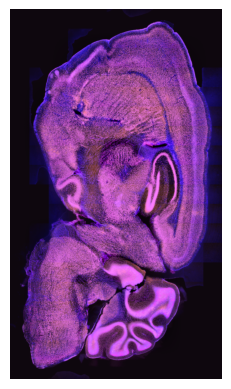

Processing SiR650_Brain_20250829_Slide_2_of_2_Region_005_channels.zarr
Using 2529124 non-zero values out of 3343536 total values
Black floor: 176.89108276367188
Lower percentile: 94.0, Upper percentile: 2859.0
Lower bound: 176.89108276367188, Upper bound: 2859.0
Dynamic range: 2682.10888671875
Gain: 24.434131622314453
Gain is too high, capping at 5
Using 2529107 non-zero values out of 3343536 total values
Black floor: 156.4780731201172
Lower percentile: 86.0, Upper percentile: 13197.0
Lower bound: 156.4780731201172, Upper bound: 13197.0
Dynamic range: 13040.521484375
Gain: 5.025489330291748
Gain is too high, capping at 5
Using 2529107 non-zero values out of 3343536 total values
Black floor: 135.0650634765625
Lower percentile: 77.0, Upper percentile: 10981.0
Lower bound: 135.0650634765625, Upper bound: 10981.0
Dynamic range: 10845.9345703125
Gain: 6.042356014251709
Gain is too high, capping at 5
Using 2529047 non-zero values out of 3343536 total values
Black floor: 165.4780731201172
Low

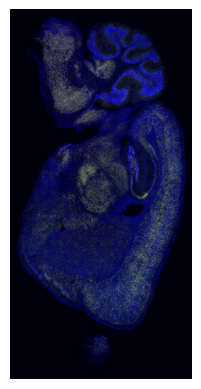

Processing SiR650_Celiacganglia_20250530_Slide_4_of_3_Region_003_channels.zarr
Using 7867881 non-zero values out of 7867881 total values
Black floor: 447.369140625
Lower percentile: 279.0, Upper percentile: 28367.0
Lower bound: 447.369140625, Upper bound: 28367.0
Dynamic range: 27919.630859375
Gain: 2.347273111343384
Using 7867881 non-zero values out of 7867881 total values
Black floor: 142.23902893066406
Lower percentile: 103.0, Upper percentile: 871.0
Lower bound: 142.23902893066406, Upper bound: 871.0
Dynamic range: 728.760986328125
Gain: 89.92660522460938
Gain is too high, capping at 5
Using 7867881 non-zero values out of 7867881 total values
Black floor: 107.82601928710938
Lower percentile: 82.0, Upper percentile: 943.0
Lower bound: 107.82601928710938, Upper bound: 943.0
Dynamic range: 835.1739501953125
Gain: 78.46868133544922
Gain is too high, capping at 5


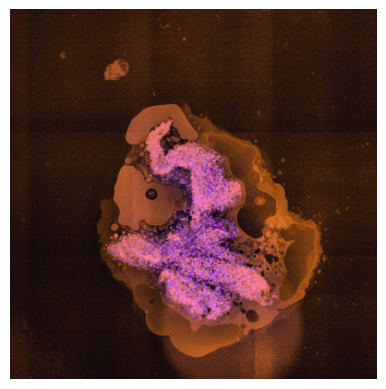

Processing SiR650_Liver_20250530_Slide_2_of_4_Region_002_channels.zarr
Using 4359784 non-zero values out of 5721625 total values
Black floor: 3464.947265625
Lower percentile: 592.0, Upper percentile: 65535.0
Lower bound: 3464.947265625, Upper bound: 65535.0
Dynamic range: 62070.0546875
Gain: 1.0558230876922607
Using 4359784 non-zero values out of 5721625 total values
Black floor: 336.78216552734375
Lower percentile: 157.0, Upper percentile: 5859.0
Lower bound: 336.78216552734375, Upper bound: 5859.0
Dynamic range: 5522.2177734375
Gain: 11.867514610290527
Gain is too high, capping at 5
Using 4359784 non-zero values out of 5721625 total values
Black floor: 125.2390365600586
Lower percentile: 89.0, Upper percentile: 1878.0
Lower bound: 125.2390365600586, Upper bound: 1878.0
Dynamic range: 1752.760986328125
Gain: 37.38957977294922
Gain is too high, capping at 5


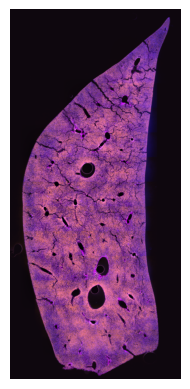

Processing SiR650_Lung_20250530_Slide_3_of_4_Region_006_channels.zarr
Using 3053190 non-zero values out of 4796940 total values
Black floor: 1428.127197265625
Lower percentile: 427.0, Upper percentile: 65535.0
Lower bound: 1428.127197265625, Upper bound: 65535.0
Dynamic range: 64106.87109375
Gain: 1.0222773551940918
Using 3053190 non-zero values out of 4796940 total values
Black floor: 186.0650634765625
Lower percentile: 124.0, Upper percentile: 1883.75
Lower bound: 186.0650634765625, Upper bound: 1883.75
Dynamic range: 1697.6849365234375
Gain: 38.602569580078125
Gain is too high, capping at 5
Using 3053190 non-zero values out of 4796940 total values
Black floor: 113.82601928710938
Lower percentile: 86.0, Upper percentile: 3979.0
Lower bound: 113.82601928710938, Upper bound: 3979.0
Dynamic range: 3865.174072265625
Gain: 16.955251693725586
Gain is too high, capping at 5


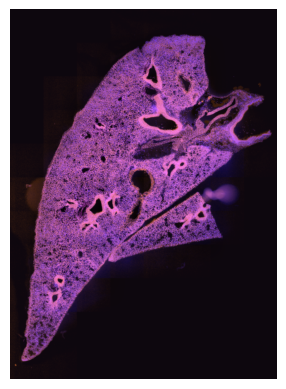

Processing SiR650_Nodoseganglia_20250530_Slide_4_of_4_Region_002_channels.zarr
Using 5456775 non-zero values out of 5456775 total values
Black floor: 653.1513061523438
Lower percentile: 342.0, Upper percentile: 65535.0
Lower bound: 653.1513061523438, Upper bound: 65535.0
Dynamic range: 64881.84765625
Gain: 1.0100667476654053
Using 5456775 non-zero values out of 5456775 total values
Black floor: 155.65203857421875
Lower percentile: 108.0, Upper percentile: 1087.0
Lower bound: 155.65203857421875, Upper bound: 1087.0
Dynamic range: 931.3479614257812
Gain: 70.36575317382812
Gain is too high, capping at 5
Using 5456775 non-zero values out of 5456775 total values
Black floor: 108.82601928710938
Lower percentile: 83.0, Upper percentile: 4713.0
Lower bound: 108.82601928710938, Upper bound: 4713.0
Dynamic range: 4604.173828125
Gain: 14.233823776245117
Gain is too high, capping at 5


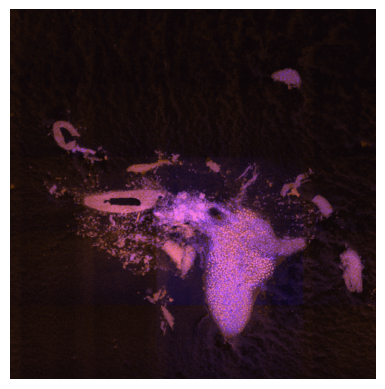

Processing SiR650_Pancreas_20250530_Slide_1_of_4_Region_002_channels.zarr
Using 7688197 non-zero values out of 13957440 total values
Black floor: 2346.344970703125
Lower percentile: 1070.0, Upper percentile: 65535.0
Lower bound: 2346.344970703125, Upper bound: 65535.0
Dynamic range: 63188.65625
Gain: 1.0371323823928833
Using 7688197 non-zero values out of 13957440 total values
Black floor: 223.89108276367188
Lower percentile: 143.0, Upper percentile: 3156.0
Lower bound: 223.89108276367188, Upper bound: 3156.0
Dynamic range: 2932.10888671875
Gain: 22.350807189941406
Gain is too high, capping at 5
Using 7688197 non-zero values out of 13957440 total values
Black floor: 114.82601928710938
Lower percentile: 87.0, Upper percentile: 2207.0
Lower bound: 114.82601928710938, Upper bound: 2207.0
Dynamic range: 2092.174072265625
Gain: 31.323875427246094
Gain is too high, capping at 5


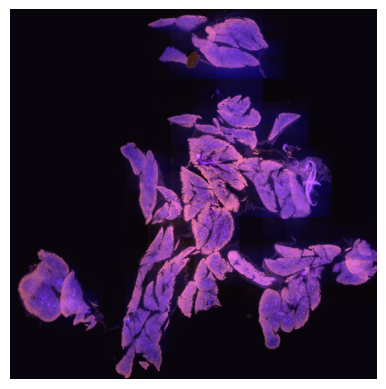

Processing SiR650_Salivarygland_20250530_Slide_2_of_3_Region_001_channels.zarr
Using 3160593 non-zero values out of 4196033 total values
Black floor: 1696.21337890625
Lower percentile: 407.0, Upper percentile: 65535.0
Lower bound: 1696.21337890625, Upper bound: 65535.0
Dynamic range: 63838.78515625
Gain: 1.0265703201293945
Using 3160593 non-zero values out of 4196033 total values
Black floor: 225.30409240722656
Lower percentile: 134.0, Upper percentile: 3157.0
Lower bound: 225.30409240722656, Upper bound: 3157.0
Dynamic range: 2931.69580078125
Gain: 22.35395622253418
Gain is too high, capping at 5
Using 3160593 non-zero values out of 4196033 total values
Black floor: 131.23902893066406
Lower percentile: 94.0, Upper percentile: 4617.0
Lower bound: 131.23902893066406, Upper bound: 4617.0
Dynamic range: 4485.7607421875
Gain: 14.609561920166016
Gain is too high, capping at 5


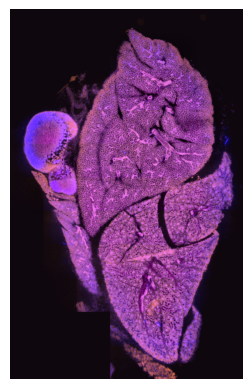

Processing SiR650_Spinalcord_20250530_Slide_3_of_3_Region_001_channels.zarr
Using 978463 non-zero values out of 1358360 total values
Black floor: 642.9122924804688
Lower percentile: 381.0, Upper percentile: 65535.0
Lower bound: 642.9122924804688, Upper bound: 65535.0
Dynamic range: 64892.0859375
Gain: 1.0099074840545654
Using 978463 non-zero values out of 1358360 total values
Black floor: 180.0650634765625
Lower percentile: 119.0, Upper percentile: 5539.5625
Lower bound: 180.0650634765625, Upper bound: 5539.5625
Dynamic range: 5359.49755859375
Gain: 12.227825164794922
Gain is too high, capping at 5
Using 978463 non-zero values out of 1358360 total values
Black floor: 109.82601928710938
Lower percentile: 84.0, Upper percentile: 11806.125
Lower bound: 109.82601928710938, Upper bound: 11806.125
Dynamic range: 11696.298828125
Gain: 5.603054523468018
Gain is too high, capping at 5


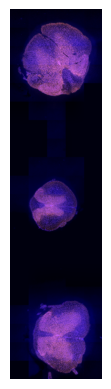

Processing SiR712_Brain_20250829_Slide_4_of_2_Region_005_channels.zarr
Using 1934069 non-zero values out of 2348004 total values
Black floor: 248.95614624023438
Lower percentile: 112.0, Upper percentile: 4246.0
Lower bound: 248.95614624023438, Upper bound: 4246.0
Dynamic range: 3997.0439453125
Gain: 16.39586639404297
Gain is too high, capping at 5
Using 1934069 non-zero values out of 2348004 total values
Black floor: 171.89108276367188
Lower percentile: 90.0, Upper percentile: 8007.0
Lower bound: 171.89108276367188, Upper bound: 8007.0
Dynamic range: 7835.10888671875
Gain: 8.364274024963379
Gain is too high, capping at 5
Using 1934061 non-zero values out of 2348004 total values
Black floor: 141.0650634765625
Lower percentile: 79.0, Upper percentile: 12806.0
Lower bound: 141.0650634765625, Upper bound: 12806.0
Dynamic range: 12664.9345703125
Gain: 5.17452335357666
Gain is too high, capping at 5
Using 1934071 non-zero values out of 2348004 total values
Black floor: 159.0650634765625
Lowe

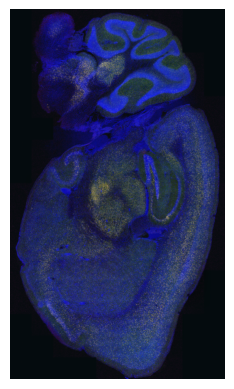

Processing TEST_JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr
Using 2623604 non-zero values out of 4129274 total values
Black floor: 178.30409240722656
Lower percentile: 57.0, Upper percentile: 1283.0
Lower bound: 178.30409240722656, Upper bound: 1283.0
Dynamic range: 1104.6959228515625
Gain: 59.32401657104492
Gain is too high, capping at 5
Using 2598422 non-zero values out of 4129274 total values
Black floor: 174.13011169433594
Lower percentile: 11.0, Upper percentile: 6244.5
Lower bound: 174.13011169433594, Upper bound: 6244.5
Dynamic range: 6070.3701171875
Gain: 10.795882225036621
Gain is too high, capping at 5
Using 2624026 non-zero values out of 4129274 total values
Black floor: 139.0650634765625
Lower percentile: 78.0, Upper percentile: 1319.0
Lower bound: 139.0650634765625, Upper bound: 1319.0
Dynamic range: 1179.9349365234375
Gain: 55.54119873046875
Gain is too high, capping at 5
Using 2600901 non-zero values out of 4129274 total values
Black floor: 192.

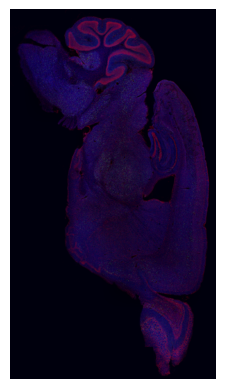

Processing TEST_JF657_Brain_20250829_Slide_4_of_1_Region_005_channels.zarr
Using 2238382 non-zero values out of 2887716 total values
Black floor: 235.54312133789062
Lower percentile: 112.0, Upper percentile: 3845.0
Lower bound: 235.54312133789062, Upper bound: 3845.0
Dynamic range: 3609.456787109375
Gain: 18.156471252441406
Gain is too high, capping at 5
Using 2238355 non-zero values out of 2887716 total values
Black floor: 167.89108276367188
Lower percentile: 88.0, Upper percentile: 15903.5
Lower bound: 167.89108276367188, Upper bound: 15903.5
Dynamic range: 15735.609375
Gain: 4.16475772857666
Using 2238317 non-zero values out of 2887716 total values
Black floor: 137.0650634765625
Lower percentile: 77.0, Upper percentile: 24700.5
Lower bound: 137.0650634765625, Upper bound: 24700.5
Dynamic range: 24563.435546875
Gain: 2.66798996925354
Using 2238384 non-zero values out of 2887716 total values
Black floor: 159.0650634765625
Lower percentile: 96.0, Upper percentile: 274.0
Lower bound: 15

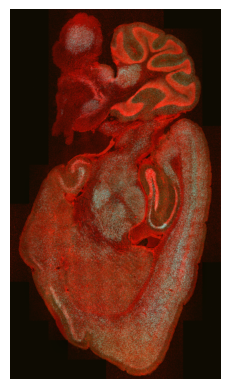

In [23]:
import os

zarr_dir = base_path
zarr_containers = [
    os.path.join(zarr_dir, d)
    for d in os.listdir(zarr_dir)
    if d.endswith(".zarr") and os.path.isdir(os.path.join(zarr_dir, d))
]

print(f"Found zarr containers: {zarr_containers}")

mips = []
for zp in zarr_containers:
    print(f"Processing {os.path.basename(zp)}")
    mip = make_mip(zp, display=False)
    plt.figure()
    plt.imshow(mip)
    plt.axis('off')
    plt.show()

